In [1]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import MessagePassing, SAGEConv
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [3]:
withGold = True
withOil = True
# lossFunction = 'CrossEntrophyLoss'
lossFunction = 'FocalLoss'

In [4]:
start_date = "2011-01-30"
end_date = "2019-08-30"
yfdata = yf.download('^GSPC', start=start_date, end=end_date)
golddata = yf.download('GC=F', start=start_date, end=end_date)
oildata = yf.download('CL=F', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
yfdata_dates = yfdata.index
golddata_dates = golddata.index

# 找出 yfdata 有而 golddata 没有的日期
missing_dates = yfdata_dates[~yfdata_dates.isin(golddata_dates)]
missing_data = pd.DataFrame(index=missing_dates,columns=golddata.columns)
for date in missing_dates:
    previous_date = golddata_dates[golddata_dates < date]
    if not previous_date.empty:
        last_known_data = golddata.loc[previous_date.max()]
        missing_data.loc[date] = last_known_data

golddata = pd.concat([golddata, missing_data])
golddata = golddata.add_prefix('gold ')
golddata = golddata.sort_index()


In [6]:
golddata.isna().any().any()

False

In [7]:
yfdata_dates = yfdata.index
oildata_dates = oildata.index

# 找出 yfdata 有而 oildata 没有的日期
missing_dates = yfdata_dates[~yfdata_dates.isin(oildata_dates)]
missing_data = pd.DataFrame(index=missing_dates,columns=oildata.columns)
for date in missing_dates:
    previous_date = oildata_dates[oildata_dates < date]
    if not previous_date.empty:
        last_known_data = oildata.loc[previous_date.max()]
        missing_data.loc[date] = last_known_data

oildata = pd.concat([oildata, missing_data])
oildata = oildata.add_prefix('oil ')
oildata = oildata.sort_index()

oildata.isna().any().any()

False

In [8]:
days = 8 #多取一天後續方便計算label
date_cols = []
price_cols = yfdata.columns.tolist()
price_cols.append('gold Adj Close')
price_cols.append('oil Adj Close')
all_data = {}
sliding_window = 1

def group_by_week(data,price_col):
    local_df = []
    for i in range(len(data)):
        if np.isnan(data[price_col][i]): 
            print(str(data.index[i]))
            break
        local_df.append(data[price_col][i])
        
        if len(local_df) == days:
            col_name = str(data.index[i - days + 1]) + ' ~ ' + str(data.index[i])
            if price_col == price_cols[0]:
                date_cols.append(col_name)
            all_data[(price_col, col_name)] = local_df.copy()
            for _ in range(sliding_window):
                local_df.pop(0) 

for price_col in price_cols:
    if price_col.startswith('gold'):
        group_by_week(golddata, price_col)
    elif price_col.startswith('oil'):
        group_by_week(oildata, price_col)
    else: 
        group_by_week(yfdata, price_col)


multi_columns = pd.MultiIndex.from_product([price_cols,date_cols],names=['price','date'])
group_by_days_yfdata = pd.DataFrame(data=all_data,columns=multi_columns)
test = group_by_days_yfdata['gold Adj Close']

C:\Users\tony\AppData\Local\Temp\ipykernel_14124\4164715537.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isnan(data[price_col][i]):
C:\Users\tony\AppData\Local\Temp\ipykernel_14124\4164715537.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  local_df.append(data[price_col][i])


In [9]:
data = group_by_days_yfdata
# data = data.fillna(0)
print("If there is NAN in data? ",data.isnull().values.any())
returns = data['Adj Close'].pct_change().fillna(0) 
print(returns.keys())
scaled_returns = StandardScaler().fit_transform(returns) #Z-score標準化:mean = 0,std = 1，後續用來計算相關性
# 計算各週之間的相關性
correlation_matrix = np.corrcoef(scaled_returns, rowvar=False)
correlation_matrix

If there is NAN in data?  False
Index(['2011-01-31 00:00:00 ~ 2011-02-09 00:00:00',
       '2011-02-01 00:00:00 ~ 2011-02-10 00:00:00',
       '2011-02-02 00:00:00 ~ 2011-02-11 00:00:00',
       '2011-02-03 00:00:00 ~ 2011-02-14 00:00:00',
       '2011-02-04 00:00:00 ~ 2011-02-15 00:00:00',
       '2011-02-07 00:00:00 ~ 2011-02-16 00:00:00',
       '2011-02-08 00:00:00 ~ 2011-02-17 00:00:00',
       '2011-02-09 00:00:00 ~ 2011-02-18 00:00:00',
       '2011-02-10 00:00:00 ~ 2011-02-22 00:00:00',
       '2011-02-11 00:00:00 ~ 2011-02-23 00:00:00',
       ...
       '2019-08-07 00:00:00 ~ 2019-08-16 00:00:00',
       '2019-08-08 00:00:00 ~ 2019-08-19 00:00:00',
       '2019-08-09 00:00:00 ~ 2019-08-20 00:00:00',
       '2019-08-12 00:00:00 ~ 2019-08-21 00:00:00',
       '2019-08-13 00:00:00 ~ 2019-08-22 00:00:00',
       '2019-08-14 00:00:00 ~ 2019-08-23 00:00:00',
       '2019-08-15 00:00:00 ~ 2019-08-26 00:00:00',
       '2019-08-16 00:00:00 ~ 2019-08-27 00:00:00',
       '2019-08-19 00

array([[ 1.        , -0.36727761, -0.27048959, ...,  0.28624785,
        -0.30040505,  0.09645067],
       [-0.36727761,  1.        ,  0.1310953 , ..., -0.59253527,
        -0.17798629, -0.23256388],
       [-0.27048959,  0.1310953 ,  1.        , ...,  0.50907856,
        -0.30571374, -0.13618199],
       ...,
       [ 0.28624785, -0.59253527,  0.50907856, ...,  1.        ,
        -0.49407569,  0.00516179],
       [-0.30040505, -0.17798629, -0.30571374, ..., -0.49407569,
         1.        , -0.29780148],
       [ 0.09645067, -0.23256388, -0.13618199, ...,  0.00516179,
        -0.29780148,  1.        ]])

In [10]:
from torch_geometric.data import Data

In [11]:
def min_max_scaling(data, feature_range=(0, 1)):
    """
    Min-Max Scaling for data.

    Parameters:
    - data: A NumPy array containing the data to be scaled.
    - feature_range: A tuple specifying the desired feature range (default is [0, 1]).

    Returns:
    - scaled_data: The scaled data within the specified feature range.
    """
    min_val, max_val = feature_range
    min_data = np.min(data, axis=0)
    max_data = np.max(data, axis=0)
    scaled_data = (data - min_data) / (max_data - min_data) * (max_val - min_val) + min_val
    return scaled_data

In [12]:
# 將相關性矩陣轉換為鄰接矩陣
adjacency_matrix = torch.tensor(correlation_matrix)

src_nodes, dst_nodes = np.where((adjacency_matrix > 0.7))
directed_index = np.where((src_nodes < dst_nodes) & ((dst_nodes - src_nodes) <= 495))
src_nodes = src_nodes[directed_index]
dst_nodes = dst_nodes[directed_index]

edge_index = torch.tensor([
    src_nodes,  
    dst_nodes  
],dtype=torch.long) #邊

features = ['Adj Close', 'Open', 'High', 'Low', 'Volume']
if (withGold):
    features.append('gold Adj Close')
if (withOil):
    features.append('oil Adj Close')
num_nodes = len(returns.keys())
num_features = len(features)
feature_matrix = np.zeros((num_nodes, num_features,len(data)-1)) 

# 將數據填充到特徵矩陣中
for i, symbol in enumerate(returns.keys()):
    for j,feature in enumerate(features):
        company_data = data[(feature,symbol)]
        feature_matrix[i, j] = torch.tensor(min_max_scaling(company_data.values[:-1]),dtype=torch.float32) #取得第一天到第七天
        
print("Any NAN in feature_matrix= ",np.isnan(feature_matrix).any())

feature_matrix = torch.tensor(feature_matrix,dtype=torch.float32)
feature_matrix = feature_matrix.reshape(feature_matrix.shape[0], -1)

y_list = []
for i, symbol in enumerate(returns.keys()):
    lastDay = data.iloc[-2][('Adj Close',symbol)] #input中最後一天的資料
    predictDay = data.iloc[-1][('Adj Close',symbol)] #隔天的資料
    if (lastDay/predictDay > 1.005):
        y_list.append([2]) #下跌
    elif ( 0.995 < lastDay/predictDay < 1.005): #應該在某個範圍內
        y_list.append([1]) #持平
    else:
        y_list.append([0]) #上漲

y = torch.tensor(y_list, dtype=torch.long)

print("feature_matrix_shape = ",feature_matrix.shape)
print("edge size= ",edge_index.shape)
print('y = ',y.shape)
gnnInputData = Data(x=feature_matrix,edge_index=edge_index,y=y)



C:\Users\tony\AppData\Local\Temp\ipykernel_14124\1094327496.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  edge_index = torch.tensor([


Any NAN in feature_matrix=  False
feature_matrix_shape =  torch.Size([2153, 49])
edge size=  torch.Size([2, 34396])
y =  torch.Size([2153, 1])


In [13]:
print(edge_index)

tensor([[   0,    0,    0,  ..., 2137, 2138, 2138],
        [  40,   55,   70,  ..., 2151, 2145, 2152]])


In [14]:
#input為有向圖，過去->未來
print(gnnInputData.is_directed())

True


In [15]:
train_eval_test_index = []
for target_value in ['~ 2013-01-30','~ 2017-05-23','~ 2018-03-27','~ 2019-08-29']:
    for index, item in enumerate(returns.keys()):
        if target_value in item:
            train_eval_test_index.append(index)
            print(f"找到日期 '{item}'，index= {index}")
            break

找到日期 '2013-01-18 00:00:00 ~ 2013-01-30 00:00:00'，index= 495
找到日期 '2017-05-12 00:00:00 ~ 2017-05-23 00:00:00'，index= 1581
找到日期 '2018-03-16 00:00:00 ~ 2018-03-27 00:00:00'，index= 1793
找到日期 '2019-08-20 00:00:00 ~ 2019-08-29 00:00:00'，index= 2152


In [16]:
train_idx = torch.tensor(np.arange(train_eval_test_index[0],train_eval_test_index[1]+1),dtype=torch.long)
#evaluate input節點
eval_idx = torch.tensor(np.arange(train_eval_test_index[1]+1,train_eval_test_index[2]+1),dtype=torch.long)
#test input
test_idx = torch.tensor(np.arange(train_eval_test_index[2]+1,len(feature_matrix)),dtype=torch.long)

In [17]:
count_0 = np.count_nonzero(y == 0)
count_1 = np.count_nonzero(y == 1)
count_2 = np.count_nonzero(y == 2)

print("上漲(0)的数量：", count_0)
print("持有(1)的数量：", count_1)
print("下跌(2)的数量：", count_2)

weight = [len(y) / (count_0 + 1e-8), len(y) / (count_1 + 1e-8), len(y) / (count_2 + 1e-8)]
print("weight: ",weight)

上漲(0)的数量： 534
持有(1)的数量： 1202
下跌(2)的数量： 417
weight:  [4.031835205917007, 1.7911813643777774, 5.1630695442406935]


In [18]:
import torch_geometric
from torch_geometric.utils import degree
import numpy
num_neighbors = [degree for degree in degree(gnnInputData.edge_index[1])]
print(num_neighbors[train_eval_test_index[0]:])
neighbor_nodes_mean = numpy.mean(num_neighbors[train_eval_test_index[0]:])
print(neighbor_nodes_mean)

[tensor(18.), tensor(16.), tensor(13.), tensor(11.), tensor(14.), tensor(16.), tensor(18.), tensor(18.), tensor(21.), tensor(15.), tensor(20.), tensor(25.), tensor(24.), tensor(19.), tensor(17.), tensor(15.), tensor(14.), tensor(16.), tensor(17.), tensor(12.), tensor(15.), tensor(18.), tensor(19.), tensor(18.), tensor(12.), tensor(17.), tensor(14.), tensor(15.), tensor(20.), tensor(22.), tensor(15.), tensor(15.), tensor(15.), tensor(20.), tensor(13.), tensor(21.), tensor(16.), tensor(18.), tensor(19.), tensor(17.), tensor(18.), tensor(21.), tensor(21.), tensor(27.), tensor(26.), tensor(23.), tensor(23.), tensor(19.), tensor(19.), tensor(23.), tensor(13.), tensor(22.), tensor(22.), tensor(24.), tensor(24.), tensor(19.), tensor(17.), tensor(17.), tensor(20.), tensor(21.), tensor(23.), tensor(20.), tensor(15.), tensor(11.), tensor(13.), tensor(11.), tensor(17.), tensor(19.), tensor(19.), tensor(21.), tensor(10.), tensor(17.), tensor(12.), tensor(16.), tensor(12.), tensor(12.), tensor(14.)

In [19]:
train_loader =  NeighborLoader(gnnInputData, input_nodes=train_idx,
                              shuffle=False, num_workers=os.cpu_count() - 2,
                              batch_size=32, num_neighbors=[neighbor_nodes_mean]*2)
total_loader = NeighborLoader(gnnInputData, input_nodes=None, num_neighbors=[-1],
                               shuffle=False,
                               num_workers=os.cpu_count() - 2)


In [20]:
#Graph Sample and Aggregation
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, n_layers=2):
        super(SAGE, self).__init__()
        self.n_layers = n_layers
        self.layers = torch.nn.ModuleList()
        self.layers_bn = torch.nn.ModuleList() #batch normalization

        if n_layers == 1:
            self.layers.append(SAGEConv(in_channels, out_channels, normalize=False))
        elif n_layers == 2:
            self.layers.append(SAGEConv(in_channels, hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))
            self.layers.append(SAGEConv(hidden_channels, out_channels, normalize=False))
        else:
            self.layers.append(SAGEConv(in_channels, hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))

        for _ in range(n_layers - 2):
            self.layers.append(SAGEConv(hidden_channels, hidden_channels, normalize=False))
            self.layers_bn.append(torch.nn.BatchNorm1d(hidden_channels))

            self.layers.append(SAGEConv(hidden_channels, out_channels, normalize=False))

        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, x, edge_index):
        if len(self.layers) > 1:
            looper = self.layers[:-1]
        else:
            looper = self.layers
        
        for i, layer in enumerate(looper):
            x = layer(x, edge_index)
            try:
                x = self.layers_bn[i](x)
            except Exception as e:
                abs(1)
            finally:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)

        if len(self.layers) > 1:
            x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=-1), torch.var(x)

    def inference(self, total_loader, device):
        xs = []
        var_ = []
        for batch in total_loader:
            out, var = self.forward(batch.x.to(device), batch.edge_index.to(device))
            out = out[:batch.batch_size]
            xs.append(out.cpu())
            var_.append(var.item())

        out_all = torch.cat(xs, dim=0)

        return out_all, var_

In [21]:
target_dataset = 'ogbn-arxiv'
def test(model, device):
    evaluator = Evaluator(name=target_dataset)
    model.eval()
    out, var = model.inference(total_loader, device)
    y_true = gnnInputData.y.cpu()
    y_pred = out.argmax(dim=-1, keepdim=True)
    
    train_acc = evaluator.eval({
        'y_true': y_true[train_idx],
        'y_pred': y_pred[train_idx],
    })['acc']
    val_acc = evaluator.eval({
        'y_true': y_true[eval_idx],
        'y_pred': y_pred[eval_idx],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[test_idx],
        'y_pred': y_pred[test_idx],
    })['acc']
    
    return train_acc, val_acc, test_acc, torch.mean(torch.Tensor(var)), y_true, out

In [22]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.nll_loss(input, target)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        self.alpha = self.alpha.to(input.device)
        if self.alpha is not None:
            focal_loss = self.alpha[target] * focal_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

def creterion(lossFunction , weight, out, y_true):
    loss = 1
    match lossFunction:
        case 'CrossEntrophyLoss':
            loss = F.nll_loss(out, torch.reshape(y_true, (-1,)))
        case 'FocalLoss':
            focalLoss = FocalLoss(gamma=2,alpha=torch.tensor(weight),reduction='mean')
            loss = focalLoss(out, torch.reshape(y_true, (-1,)))

    return loss

In [23]:
title = lossFunction
if withGold: title += ' with gold'
if withOil: title += ' with oil'
if not os.path.exists(f'result/{lossFunction}/'):
    os.makedirs(f'result/{lossFunction}/')
if not os.path.exists(f'result/{lossFunction}/{title}'):
    os.makedirs(f'result/{lossFunction}/{title}')
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(gnnInputData.x.shape[1], 256, 3, n_layers=2)
model.to(device)
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

import matplotlib.pyplot as plt
from early_stopping import EarlyStopping
save_path = f'result/{lossFunction}/{title}/'
early_stopping = EarlyStopping(save_path,patience=15,verbose=True)

train_accs = []
val_accs = []
test_accs = []
total_train_loss = []
total_eval_loss = []
total_test_loss = []
for epoch in range(1, epochs):
    model.train()
    pbar = tqdm(total=len(train_idx))
    pbar.set_description(f'Epoch {epoch:02d}')
    batch_loss = total_correct = 0
    for batch in train_loader:
        batch_size = batch.batch_size
        optimizer.zero_grad()
        out, _ = model(batch.x.to(device), batch.edge_index.to(device))
        out = out[:batch_size]
        batch_y = batch.y[:batch_size].to(device)
        batch_y = torch.reshape(batch_y, (-1,))
        loss = creterion(lossFunction, weight, out, batch_y)
        loss.backward()
        optimizer.step()
        batch_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq(batch_y).sum())
        pbar.update(batch.batch_size)
    pbar.close()
    # loss = batch_loss / len(train_loader)
    approx_acc = total_correct / train_idx.size(0)
    train_acc, val_acc, test_acc, var, y_true, out = test(model, device)
    train_loss = creterion(lossFunction, weight, out[train_idx], torch.reshape(y_true[train_idx], (-1,)))  
    eval_loss = creterion(lossFunction, weight, out[eval_idx], torch.reshape(y_true[eval_idx], (-1,)))
    test_loss = creterion(lossFunction, weight, out[test_idx], torch.reshape(y_true[test_idx], (-1,)))
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    total_train_loss.append(train_loss)
    total_eval_loss.append(eval_loss)
    total_test_loss.append(test_loss)
    scheduler.step(eval_loss)

    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    cm = confusion_matrix(y_true[test_idx], out[test_idx].argmax(dim=-1, keepdim=True))

    print(f'TrainAcc: {train_acc:.4f}, ValAcc: {val_acc:.4f}, TestAcc: {test_acc:.4f}, trainLoss: {train_loss:.4f}, evalLoss: {eval_loss:.4f}, testLoss: {test_loss:.4f}')
    #early_stopping
    early_stopping(test_loss, model, confusion_matrix=cm, epoch=epoch, test_acc=test_acc, test_loss=test_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break 

Epoch 01: 100%|██████████| 1087/1087 [00:08<00:00, 134.11it/s]


TrainAcc: 0.5722, ValAcc: 0.6934, TestAcc: 0.5209, trainLoss: 1.1105, evalLoss: 0.7600, testLoss: 1.2584
Validation loss decreased (inf --> 1.258411).  Saving model ...
[[  2  93   0]
 [  2 185   1]
 [  2  74   0]]


Epoch 02: 100%|██████████| 1087/1087 [00:04<00:00, 225.78it/s]


TrainAcc: 0.5814, ValAcc: 0.6981, TestAcc: 0.5320, trainLoss: 1.0154, evalLoss: 0.6408, testLoss: 1.2035
Validation loss decreased (1.258411 --> 1.203451).  Saving model ...
[[  3  92   0]
 [  0 188   0]
 [  1  75   0]]


Epoch 03: 100%|██████████| 1087/1087 [00:03<00:00, 272.51it/s]


TrainAcc: 0.5952, ValAcc: 0.6981, TestAcc: 0.5320, trainLoss: 0.9722, evalLoss: 0.6293, testLoss: 1.1525
Validation loss decreased (1.203451 --> 1.152463).  Saving model ...
[[  4  91   0]
 [  1 187   0]
 [  1  75   0]]


Epoch 04: 100%|██████████| 1087/1087 [00:03<00:00, 281.52it/s]


TrainAcc: 0.5989, ValAcc: 0.7075, TestAcc: 0.5292, trainLoss: 0.9354, evalLoss: 0.6118, testLoss: 1.1211
Validation loss decreased (1.152463 --> 1.121065).  Saving model ...
[[  3  92   0]
 [  2 186   0]
 [  0  75   1]]


Epoch 05: 100%|██████████| 1087/1087 [00:03<00:00, 277.45it/s]


TrainAcc: 0.6081, ValAcc: 0.6934, TestAcc: 0.5404, trainLoss: 0.9080, evalLoss: 0.6040, testLoss: 1.0954
Validation loss decreased (1.121065 --> 1.095421).  Saving model ...
[[  6  89   0]
 [  2 186   0]
 [  1  73   2]]


Epoch 06: 100%|██████████| 1087/1087 [00:03<00:00, 285.31it/s]


TrainAcc: 0.6118, ValAcc: 0.6840, TestAcc: 0.5404, trainLoss: 0.8872, evalLoss: 0.6039, testLoss: 1.0742
Validation loss decreased (1.095421 --> 1.074162).  Saving model ...
[[  9  86   0]
 [  5 182   1]
 [  3  70   3]]


Epoch 07: 100%|██████████| 1087/1087 [00:04<00:00, 271.18it/s]


TrainAcc: 0.6256, ValAcc: 0.6981, TestAcc: 0.5460, trainLoss: 0.8684, evalLoss: 0.5974, testLoss: 1.0632
Validation loss decreased (1.074162 --> 1.063192).  Saving model ...
[[ 11  84   0]
 [  5 182   1]
 [  2  71   3]]


Epoch 08: 100%|██████████| 1087/1087 [00:03<00:00, 288.92it/s]


TrainAcc: 0.6385, ValAcc: 0.6981, TestAcc: 0.5460, trainLoss: 0.8494, evalLoss: 0.5886, testLoss: 1.0492
Validation loss decreased (1.063192 --> 1.049207).  Saving model ...
[[ 12  83   0]
 [  7 180   1]
 [  1  71   4]]


Epoch 09: 100%|██████████| 1087/1087 [00:03<00:00, 291.82it/s]


TrainAcc: 0.6375, ValAcc: 0.7028, TestAcc: 0.5543, trainLoss: 0.8346, evalLoss: 0.5879, testLoss: 1.0394
Validation loss decreased (1.049207 --> 1.039376).  Saving model ...
[[ 15  80   0]
 [  7 180   1]
 [  1  71   4]]


Epoch 10: 100%|██████████| 1087/1087 [00:03<00:00, 298.94it/s]


TrainAcc: 0.6412, ValAcc: 0.7028, TestAcc: 0.5571, trainLoss: 0.8221, evalLoss: 0.5897, testLoss: 1.0303
Validation loss decreased (1.039376 --> 1.030260).  Saving model ...
[[ 16  79   0]
 [  7 180   1]
 [  1  71   4]]


Epoch 11: 100%|██████████| 1087/1087 [00:03<00:00, 291.73it/s]


TrainAcc: 0.6366, ValAcc: 0.7028, TestAcc: 0.5599, trainLoss: 0.8179, evalLoss: 0.5975, testLoss: 1.0233
Validation loss decreased (1.030260 --> 1.023257).  Saving model ...
[[ 21  74   0]
 [ 11 176   1]
 [  3  69   4]]


Epoch 12: 100%|██████████| 1087/1087 [00:03<00:00, 284.92it/s]


TrainAcc: 0.6403, ValAcc: 0.7028, TestAcc: 0.5599, trainLoss: 0.8072, evalLoss: 0.5973, testLoss: 1.0215
Validation loss decreased (1.023257 --> 1.021459).  Saving model ...
[[ 22  73   0]
 [ 12 175   1]
 [  3  69   4]]


Epoch 13: 100%|██████████| 1087/1087 [00:03<00:00, 289.75it/s]


TrainAcc: 0.6403, ValAcc: 0.7123, TestAcc: 0.5655, trainLoss: 0.8018, evalLoss: 0.6019, testLoss: 1.0207
Validation loss decreased (1.021459 --> 1.020689).  Saving model ...
[[ 24  71   0]
 [ 12 175   1]
 [  3  69   4]]


Epoch 14: 100%|██████████| 1087/1087 [00:03<00:00, 296.34it/s]


TrainAcc: 0.6403, ValAcc: 0.7123, TestAcc: 0.5655, trainLoss: 0.8016, evalLoss: 0.6012, testLoss: 1.0211
EarlyStopping counter: 1 out of 15


Epoch 15: 100%|██████████| 1087/1087 [00:04<00:00, 264.81it/s]


TrainAcc: 0.6412, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.8002, evalLoss: 0.5995, testLoss: 1.0213
EarlyStopping counter: 2 out of 15


Epoch 16: 100%|██████████| 1087/1087 [00:04<00:00, 267.51it/s]


TrainAcc: 0.6412, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7982, evalLoss: 0.5980, testLoss: 1.0205
Validation loss decreased (1.020689 --> 1.020493).  Saving model ...
[[ 24  71   0]
 [ 12 176   0]
 [  3  69   4]]


Epoch 17: 100%|██████████| 1087/1087 [00:03<00:00, 283.06it/s]


TrainAcc: 0.6412, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7979, evalLoss: 0.5983, testLoss: 1.0205
Validation loss decreased (1.020493 --> 1.020492).  Saving model ...
[[ 24  71   0]
 [ 12 176   0]
 [  3  69   4]]


Epoch 18: 100%|██████████| 1087/1087 [00:04<00:00, 261.43it/s]


TrainAcc: 0.6412, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7980, evalLoss: 0.5984, testLoss: 1.0205
Validation loss decreased (1.020492 --> 1.020460).  Saving model ...
[[ 24  71   0]
 [ 12 176   0]
 [  3  69   4]]


Epoch 19: 100%|██████████| 1087/1087 [00:03<00:00, 281.48it/s]


TrainAcc: 0.6421, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7978, evalLoss: 0.5983, testLoss: 1.0204
Validation loss decreased (1.020460 --> 1.020389).  Saving model ...
[[ 24  71   0]
 [ 12 176   0]
 [  3  69   4]]


Epoch 20: 100%|██████████| 1087/1087 [00:03<00:00, 285.17it/s]


TrainAcc: 0.6421, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7975, evalLoss: 0.5981, testLoss: 1.0204
Validation loss decreased (1.020389 --> 1.020371).  Saving model ...
[[ 24  71   0]
 [ 12 176   0]
 [  3  69   4]]


Epoch 21: 100%|██████████| 1087/1087 [00:03<00:00, 273.15it/s]


TrainAcc: 0.6412, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7976, evalLoss: 0.5981, testLoss: 1.0205
EarlyStopping counter: 1 out of 15


Epoch 22: 100%|██████████| 1087/1087 [00:04<00:00, 257.42it/s]


TrainAcc: 0.6421, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7977, evalLoss: 0.5983, testLoss: 1.0206
EarlyStopping counter: 2 out of 15


Epoch 23: 100%|██████████| 1087/1087 [00:03<00:00, 285.86it/s]


TrainAcc: 0.6412, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7975, evalLoss: 0.5982, testLoss: 1.0205
EarlyStopping counter: 3 out of 15


Epoch 24: 100%|██████████| 1087/1087 [00:04<00:00, 245.67it/s]


TrainAcc: 0.6412, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7982, evalLoss: 0.5988, testLoss: 1.0208
EarlyStopping counter: 4 out of 15


Epoch 25: 100%|██████████| 1087/1087 [00:04<00:00, 264.23it/s]


TrainAcc: 0.6421, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7975, evalLoss: 0.5981, testLoss: 1.0205
EarlyStopping counter: 5 out of 15


Epoch 26: 100%|██████████| 1087/1087 [00:03<00:00, 284.50it/s]


TrainAcc: 0.6421, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7976, evalLoss: 0.5982, testLoss: 1.0206
EarlyStopping counter: 6 out of 15


Epoch 27: 100%|██████████| 1087/1087 [00:04<00:00, 250.15it/s]


TrainAcc: 0.6421, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7977, evalLoss: 0.5984, testLoss: 1.0206
EarlyStopping counter: 7 out of 15


Epoch 28: 100%|██████████| 1087/1087 [00:04<00:00, 242.11it/s]


TrainAcc: 0.6412, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7973, evalLoss: 0.5978, testLoss: 1.0207
EarlyStopping counter: 8 out of 15


Epoch 29: 100%|██████████| 1087/1087 [00:03<00:00, 278.97it/s]


TrainAcc: 0.6412, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7982, evalLoss: 0.5988, testLoss: 1.0209
EarlyStopping counter: 9 out of 15


Epoch 30: 100%|██████████| 1087/1087 [00:04<00:00, 267.17it/s]


TrainAcc: 0.6421, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7977, evalLoss: 0.5981, testLoss: 1.0207
EarlyStopping counter: 10 out of 15


Epoch 31: 100%|██████████| 1087/1087 [00:03<00:00, 292.14it/s]


TrainAcc: 0.6421, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7979, evalLoss: 0.5985, testLoss: 1.0206
EarlyStopping counter: 11 out of 15


Epoch 32: 100%|██████████| 1087/1087 [00:03<00:00, 293.98it/s]


TrainAcc: 0.6421, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7978, evalLoss: 0.5983, testLoss: 1.0207
EarlyStopping counter: 12 out of 15


Epoch 33: 100%|██████████| 1087/1087 [00:03<00:00, 279.96it/s]


TrainAcc: 0.6421, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7978, evalLoss: 0.5985, testLoss: 1.0205
EarlyStopping counter: 13 out of 15


Epoch 34: 100%|██████████| 1087/1087 [00:03<00:00, 292.65it/s]


TrainAcc: 0.6421, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7973, evalLoss: 0.5979, testLoss: 1.0206
EarlyStopping counter: 14 out of 15


Epoch 35: 100%|██████████| 1087/1087 [00:03<00:00, 294.44it/s]


TrainAcc: 0.6412, ValAcc: 0.7123, TestAcc: 0.5682, trainLoss: 0.7973, evalLoss: 0.5978, testLoss: 1.0205
EarlyStopping counter: 15 out of 15
Early stopping


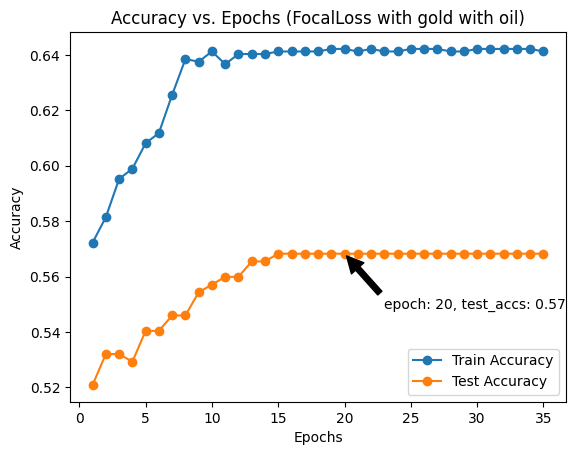

In [27]:
plt.plot(np.arange(1, len(train_accs)+1), train_accs, label='Train Accuracy', marker='o')
# plt.plot(np.arange(0, len(val_accs)), val_accs, label='Validation Accuracy', marker='o')
plt.plot(np.arange(1, len(test_accs)+1), test_accs, label='Test Accuracy', marker='o')

plt.annotate(f'epoch: {early_stopping.best_epoch}, test_accs: {test_accs[early_stopping.best_epoch-1]:.2f}', 
             xy=(early_stopping.best_epoch, test_accs[early_stopping.best_epoch-1]), 
             xytext=(early_stopping.best_epoch + 3, test_accs[early_stopping.best_epoch-1] - 0.02),  # 文本的位置
             arrowprops=dict(facecolor='black', shrink=0.05),  # 箭頭的屬性
             )

plt.legend()
plt.title(f'Accuracy vs. Epochs ({title})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig(f'result/{lossFunction}/{title}/acc.png',bbox_inches = 'tight')
plt.show()

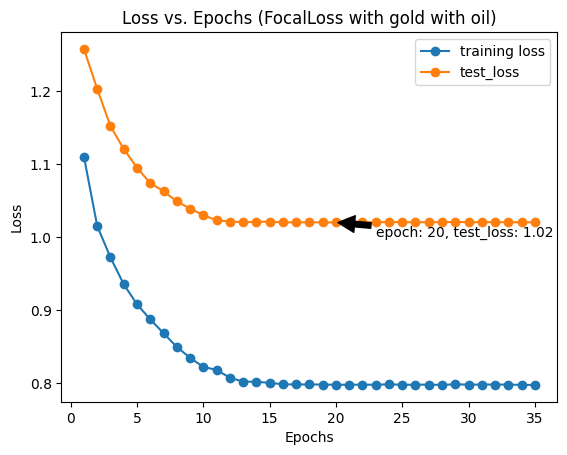

In [28]:
plt.plot(np.arange(1, len(total_train_loss)+1), [tensor.item() for tensor in total_train_loss], label='training loss', marker='o')
plt.plot(np.arange(1, len(total_test_loss)+1), [tensor.item() for tensor in total_test_loss], label='test_loss', marker='o')

plt.legend()
plt.annotate(f'epoch: {early_stopping.best_epoch}, test_loss: {total_test_loss[early_stopping.best_epoch-1]:.2f}', 
             xy=(early_stopping.best_epoch, total_test_loss[early_stopping.best_epoch-1]), 
             xytext=(early_stopping.best_epoch + 3, total_test_loss[early_stopping.best_epoch-1] - 0.02),  # 文本的位置
             arrowprops=dict(facecolor='black', shrink=0.05),  # 箭頭的屬性
             )

plt.title(f'Loss vs. Epochs ({title})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(f'result/{lossFunction}/{title}/loss.png',bbox_inches = 'tight')
plt.show()

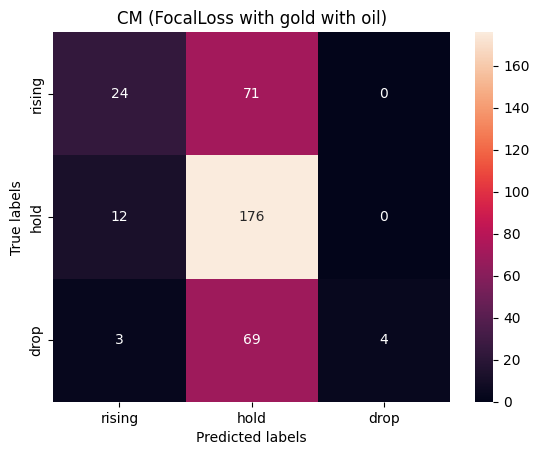

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
labels=['rising','hold','drop']     

fig, ax= plt.subplots()
sns.heatmap(early_stopping.best_test_confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CM (' + title +')')
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
fig.savefig(f'result/{lossFunction}/{title}/cm.png',bbox_inches = 'tight')